# **Practical assignment for Topic 11**

In the assignment, you have to use the dataset `auto-lpkm.tsv` given in the lecture and you should use the **gplearn** library.

Your assignment consists of **just one task**:
<br>
<br>

**Task 1**<br>
Explore configurations of the algorithm and try to find a better configuration than the one used in the lecture. Approach this task systematically. How results depend on the parameters?

Special notes to follow:
* You are not allowed to set `population_size` larger than 200.
* You are not allowed to set `generations` larger than 20.
* You have to keep `max_samples=1`, `random_state=42`, and `warm_start=False`.

When you are finished, write conclusions about the process and the findings.

In [1]:
import os
import pathlib
import shutil
import subprocess
import sys
import warnings
import zipfile
import urllib.request

TARGET_SKLEARN = "1.4.2"
LEGACY_SKLEARN_DIR = pathlib.Path('_sklearn_legacy')
LEGACY_SKLEARN_DIR.mkdir(exist_ok=True)
legacy_path = str(LEGACY_SKLEARN_DIR.resolve())
if not (LEGACY_SKLEARN_DIR / 'sklearn').exists():
    try:
        subprocess.check_call([
            sys.executable,
            '-m',
            'pip',
            'install',
            f'scikit-learn=={TARGET_SKLEARN}',
            '--target',
            legacy_path,
        ])
    except subprocess.CalledProcessError as exc:
        warnings.warn(
            'Unable to build a notebook-local scikit-learn '
            f'{TARGET_SKLEARN} with this Python interpreter. \nFalling back to the system installation'
            f'pip command: {exc.cmd}\n'
            f'exit status: {exc.returncode}'
        )
if (LEGACY_SKLEARN_DIR / 'sklearn').exists() and legacy_path not in sys.path:
    sys.path.insert(0, legacy_path)

import sklearn
print(f"Using scikit-learn {sklearn.__version__} from {sklearn.__file__}")

GRAPHVIZ_VERSION = "14.0.4"
GRAPHVIZ_ZIP_NAME = f"windows_10_cmake_Release_Graphviz-{GRAPHVIZ_VERSION}-win64.zip"
GRAPHVIZ_BASE_URL = "https://gitlab.com/api/v4/projects/4207231/packages/generic/graphviz-releases"
GRAPHVIZ_DIR = pathlib.Path('_graphviz_bin')
GRAPHVIZ_DIR.mkdir(exist_ok=True)
GRAPHVIZ_ZIP_PATH = GRAPHVIZ_DIR / GRAPHVIZ_ZIP_NAME
GRAPHVIZ_EXTRACTED_DIR = GRAPHVIZ_DIR / f"Graphviz-{GRAPHVIZ_VERSION}-win64"
DOT_PATH = GRAPHVIZ_EXTRACTED_DIR / 'bin' / 'dot.exe'
if not DOT_PATH.exists():
    try:
        if not GRAPHVIZ_ZIP_PATH.exists():
            print(f'Downloading Graphviz {GRAPHVIZ_VERSION} to {GRAPHVIZ_ZIP_PATH}...')
            with urllib.request.urlopen(f"{GRAPHVIZ_BASE_URL}/{GRAPHVIZ_VERSION}/{GRAPHVIZ_ZIP_NAME}") as response, open(GRAPHVIZ_ZIP_PATH, 'wb') as fh:
                fh.write(response.read())
        if GRAPHVIZ_EXTRACTED_DIR.exists():
            shutil.rmtree(GRAPHVIZ_EXTRACTED_DIR)
        with zipfile.ZipFile(GRAPHVIZ_ZIP_PATH) as archive:
            archive.extractall(GRAPHVIZ_DIR)
        GRAPHVIZ_ZIP_PATH.unlink(missing_ok=True)
    except Exception as exc:
        warnings.warn(f'Unable to bootstrap Graphviz binaries automatically: {exc}')
if DOT_PATH.exists():
    os.environ['PATH'] = str(DOT_PATH.parent) + os.pathsep + os.environ.get('PATH', '')
    os.environ['GRAPHVIZ_DOT'] = str(DOT_PATH)
    print(f"Using Graphviz dot at {DOT_PATH}")
else:
    warnings.warn('Graphviz dot executable not found; install it manually from https://graphviz.org/download/.')

from sklearn.base import BaseEstimator
if not hasattr(BaseEstimator, '_validate_data'):
    from sklearn.utils.validation import check_array, check_X_y

    def _validate_data(self, X, y=None, reset=True, **check_params):
        """Compatibility shim for packages expecting the legacy API."""
        if y is None:
            X_checked = check_array(X, **check_params)
            if hasattr(X_checked, 'shape'):
                self.n_features_in_ = X_checked.shape[1]
            return X_checked
        X_checked, y_checked = check_X_y(X, y, **check_params)
        if hasattr(X_checked, 'shape'):
            self.n_features_in_ = X_checked.shape[1]
        return X_checked, y_checked

    BaseEstimator._validate_data = _validate_data
    print('Injected legacy _validate_data into sklearn BaseEstimator for gplearn compatibility.')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
!pip install graphviz
import graphviz

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_predict, ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score
!pip install gplearn
from gplearn.genetic import SymbolicRegressor


C:\Users\loicm\AppData\Local\Temp\ipykernel_43212\828117860.py:26: UserWarning: Unable to build a notebook-local scikit-learn 1.4.2 with this Python interpreter. 
Falling back to the system installationpip command: ['c:\\Users\\loicm\\AppData\\Local\\Programs\\Python\\Python313\\python.exe', '-m', 'pip', 'install', 'scikit-learn==1.4.2', '--target', 'C:\\Users\\loicm\\Desktop\\Code\\Machine Learning RTU\\machine-learning-rtu\\_sklearn_legacy']
exit status: 1
  warnings.warn(


Using scikit-learn 1.7.2 from c:\Users\loicm\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\__init__.py
Using Graphviz dot at _graphviz_bin\Graphviz-14.0.4-win64\bin\dot.exe
Injected legacy _validate_data into sklearn BaseEstimator for gplearn compatibility.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
data = pd.read_csv('auto-lpkm.tsv', sep='\t', header=0)
data

,id,cylinders,displacement,horsepower,weight_lbs,weight_kg,acceleration,model_year,color,more_info_1,more_info_2,more_info_3,more_info_4,more_info_5,l100km
0,0,4,98.0,79,2255,1023,17.7,76,1,94,91,49,97,68,9.0
1,1,4,113.0,95,2278,1033,15.5,72,4,97,58,66,85,38,9.8
2,2,8,351.0,153,4129,1873,13.0,72,1,41,8,15,83,70,16.8
3,3,4,97.0,88,2279,1034,19.0,73,2,53,3,42,2,82,11.8
4,4,6,199.0,97,2774,1258,15.5,70,0,74,53,24,51,53,13.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,4,91.0,67,1995,905,16.2,82,4,48,61,22,29,3,6.2
196,196,4,140.0,90,2408,1092,19.5,72,3,81,43,46,100,13,11.8
197,197,4,135.0,84,2370,1075,13.0,82,2,32,57,13,52,6,6.5
198,198,4,91.0,68,2025,918,18.2,82,4,55,88,70,53,54,6.4


In [3]:
X = data.to_numpy()[:, 0:-1]
y = data.to_numpy()[:, -1]
data = data.drop('l100km', axis=1)
feature_names = data.columns.values
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [4]:
model = SymbolicRegressor(population_size=200,    # number of individuals in a population
                          generations=20,         # number of iterations
                          init_depth=(2,6),       # min and max tree sizes for primordial soup
                          const_range=(-10,10),   # range of values for constants in a tree
                          metric='mse',           # measure to optimize for
                          function_set=('add', 'sub', 'mul', 'div', 'sqrt', 'log', 'inv'),
                          stopping_criteria=0.01, # a little penalty for tree complexity
                          p_crossover=0.75,       # crossover probability
                          p_subtree_mutation=0.1, # subtree mutation probability
                          p_point_mutation=0.1,   # separate leaf mutation probability
                          max_samples=1,          # how many samples to use for training
                          feature_names=feature_names,
                          random_state=42,
                          verbose=1)
model.fit(X, y)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.87          94931.3        3           15.446              N/A      1.34s
   1     9.83          316.888        3           15.446              N/A      1.30s
   2     6.89           588.26       10          9.23746              N/A      1.52s
   3     4.79          56.2143       10           5.6046              N/A      1.39s
   4     7.85          109.574       12          3.59535              N/A      1.08s
   5    11.01          61.5157       20          3.22549              N/A      1.02s
   6    12.79          86.2937       18          3.08355              N/A      1.30s
   7    14.56          57.4538       16          3.08355              N/A      0.88s
   8    18.72          59.5184       31          3.05934              N/A  

,population_size,200
,generations,20
,tournament_size,20
,stopping_criteria,0.01
,const_range,"(-10, ...)"
,init_depth,"(2, ...)"
,init_method,'half and half'
,function_set,"('add', ...)"
,metric,'mse'
,parsimony_coefficient,0.001
,p_crossover,0.75


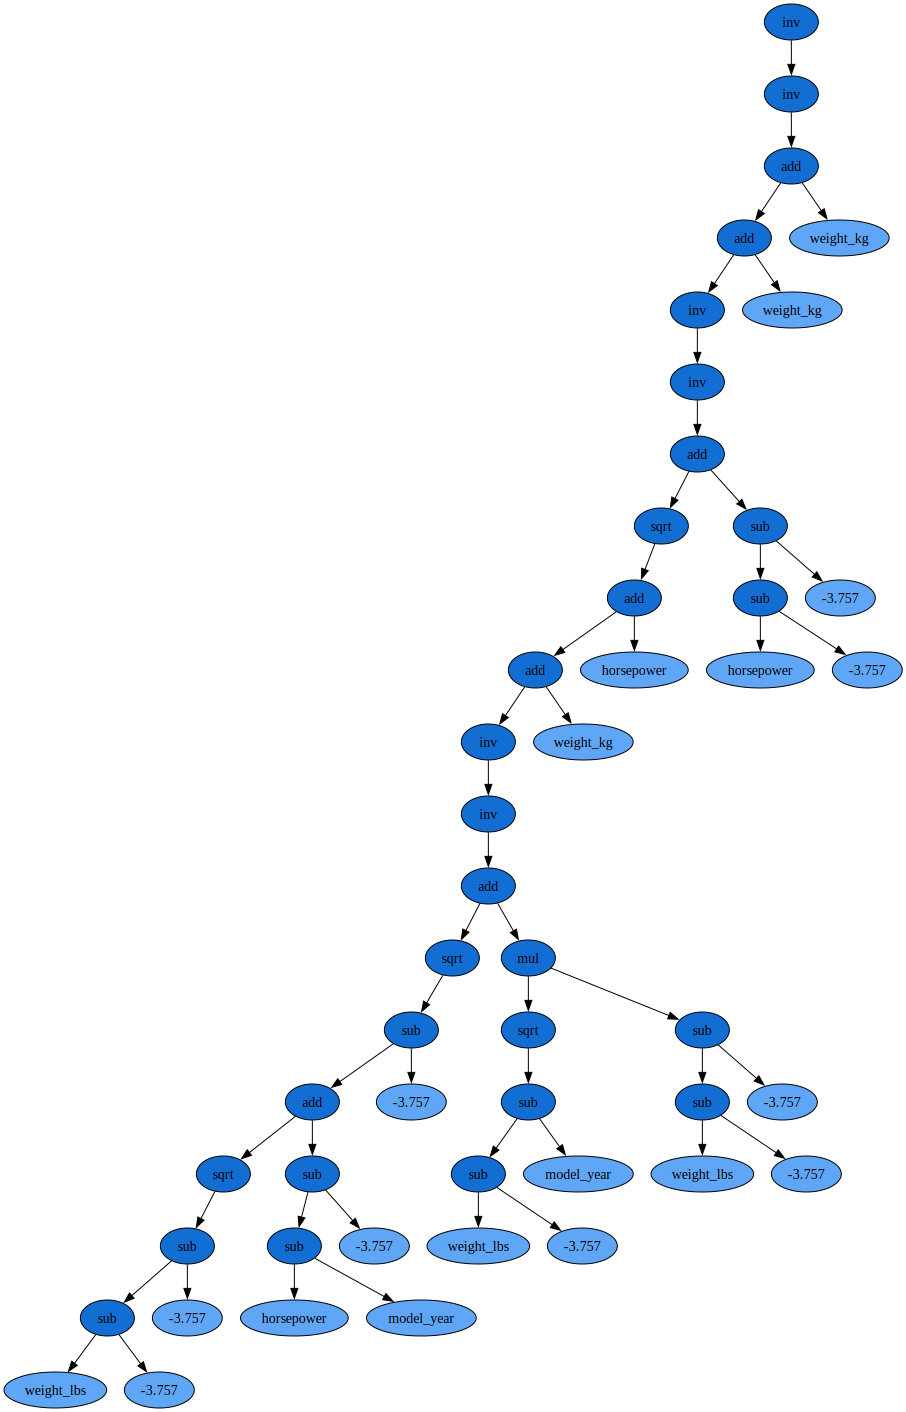

In [5]:
dot_data = model._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [6]:
model = SymbolicRegressor(population_size=200,
                          generations=20,
                          init_depth=(2,6),
                          const_range=(-10,10),
                          metric='mse',
                          function_set=('add', 'sub', 'mul', 'div', 'sqrt', 'log', 'inv'),
                          stopping_criteria=0.01,
                          p_crossover=0.75,
                          p_subtree_mutation=0.1,
                          p_point_mutation=0.1,
                          max_samples=1,
                          feature_names=feature_names,
                          random_state=42)

yHat = cross_val_predict(model, X, y, cv=10)

MSE = mean_squared_error(y, yHat)
R2 = r2_score(y, yHat)

print('Result with all features:')
print('MSE: %.3f' % MSE)
print('R^2: %.3f' % R2)

Result with all features:
MSE: 2.906
R^2: 0.802


In [7]:
from copy import deepcopy

BASE_FUNCTIONS = ('add', 'sub', 'mul', 'div', 'sqrt', 'log', 'inv')
search_space = ParameterGrid({
    'init_depth': [(2, 6), (2, 8)],
    'const_range': [(-10, 10), (-5, 5)],
    'function_set': [
        BASE_FUNCTIONS,
        BASE_FUNCTIONS + ('sin', 'cos'),
    ],
    'stopping_criteria': [0.0, 0.01],
})
mutation_schedules = [
    {'p_crossover': 0.75, 'p_subtree_mutation': 0.10, 'p_point_mutation': 0.10},
    {'p_crossover': 0.70, 'p_subtree_mutation': 0.20, 'p_point_mutation': 0.05},
    {'p_crossover': 0.65, 'p_subtree_mutation': 0.15, 'p_point_mutation': 0.15},
]

common_params = dict(
    population_size=200,
    generations=20,
    metric='mse',
    max_samples=1,
    feature_names=feature_names,
    random_state=42,
    verbose=0,
)

results = []
for grid_params in search_space:
    for mutation in mutation_schedules:
        params = deepcopy(common_params)
        params.update(grid_params)
        params.update(mutation)
        model = SymbolicRegressor(**params)
        y_pred = cross_val_predict(model, X, y, cv=5)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        results.append({
            'init_depth': f"{grid_params['init_depth']}",
            'const_range': f"{grid_params['const_range']}",
            'functions': 'base' if grid_params['function_set'] == BASE_FUNCTIONS else 'base+trig',
            'stopping_criteria': grid_params['stopping_criteria'],
            'p_crossover': mutation['p_crossover'],
            'p_subtree_mutation': mutation['p_subtree_mutation'],
            'p_point_mutation': mutation['p_point_mutation'],
            'MSE': mse,
            'R2': r2,
        })

results_df = (pd.DataFrame(results)
              .sort_values(['MSE', 'R2'], ascending=[True, False])
              .reset_index(drop=True))
print(f"Evaluated {len(results_df)} configurations.")
styled_results = (results_df.style
                  .format({'MSE': '{:.4f}', 'R2': '{:.4f}'})
                  .background_gradient(cmap='RdYlGn_r', subset=['MSE'])
                  .background_gradient(cmap='RdYlGn', subset=['R2'])
                  .set_caption('SymbolicRegressor configuration sweep (5-fold CV)'))
styled_results


Evaluated 48 configurations.


,init_depth,const_range,functions,stopping_criteria,p_crossover,p_subtree_mutation,p_point_mutation,MSE,R2
0,"(2, 6)","(-5, 5)",base+trig,0.000000,0.650000,0.150000,0.150000,2.2813,0.8442
1,"(2, 6)","(-5, 5)",base+trig,0.010000,0.650000,0.150000,0.150000,2.2813,0.8442
2,"(2, 6)","(-5, 5)",base,0.000000,0.650000,0.150000,0.150000,2.3909,0.8367
3,"(2, 6)","(-5, 5)",base,0.010000,0.650000,0.150000,0.150000,2.3909,0.8367
4,"(2, 6)","(-5, 5)",base,0.000000,0.700000,0.200000,0.050000,2.4223,0.8346
5,"(2, 6)","(-5, 5)",base,0.010000,0.700000,0.200000,0.050000,2.4223,0.8346
6,"(2, 8)","(-10, 10)",base,0.000000,0.650000,0.150000,0.150000,2.5093,0.8286
7,"(2, 8)","(-10, 10)",base,0.010000,0.650000,0.150000,0.150000,2.5093,0.8286
8,"(2, 6)","(-10, 10)",base,0.000000,0.750000,0.100000,0.100000,2.7314,0.8135
9,"(2, 6)","(-10, 10)",base,0.010000,0.750000,0.100000,0.100000,2.7314,0.8135


In [8]:
if 'results_df' not in globals():
    raise RuntimeError('Please run the configuration sweep cell before executing this block again.')

best_row = results_df.iloc[0]

def _parse_tuple(text):
    values = [int(part.strip()) for part in text.strip('()').split(',')]
    return tuple(values)

def _parse_float_tuple(text):
    values = [float(part.strip()) for part in text.strip('()').split(',')]
    return tuple(values)

function_set = BASE_FUNCTIONS if best_row['functions'] == 'base' else BASE_FUNCTIONS + ('sin', 'cos')

best_params = dict(
    population_size=200,
    generations=20,
    metric='mse',
    max_samples=1,
    feature_names=feature_names,
    random_state=42,
    init_depth=_parse_tuple(best_row['init_depth']),
    const_range=_parse_float_tuple(best_row['const_range']),
    function_set=function_set,
    stopping_criteria=float(best_row['stopping_criteria']),
    p_crossover=float(best_row['p_crossover']),
    p_subtree_mutation=float(best_row['p_subtree_mutation']),
    p_point_mutation=float(best_row['p_point_mutation']),
    verbose=1,
)

print('Selected hyperparameters:')
for key, value in best_params.items():
    print(f"- {key}: {value}")

best_model = SymbolicRegressor(**best_params)
best_model.fit(X, y)

cv_model = SymbolicRegressor(**{**best_params, 'verbose': 0})
cv_pred = cross_val_predict(cv_model, X, y, cv=5)
cv_mse = mean_squared_error(y, cv_pred)
cv_r2 = r2_score(y, cv_pred)

print(f"\n5-fold cross-validation -> MSE: {cv_mse:.4f}, R2: {cv_r2:.4f}")
print(f"Model program: {best_model._program}")


Selected hyperparameters:
- population_size: 200
- generations: 20
- metric: mse
- max_samples: 1
- feature_names: ['id' 'cylinders' 'displacement' 'horsepower' 'weight_lbs' 'weight_kg'
 'acceleration' 'model_year' 'color' 'more_info_1' 'more_info_2'
 'more_info_3' 'more_info_4' 'more_info_5']
- random_state: 42
- init_depth: (2, 6)
- const_range: (-5.0, 5.0)
- function_set: ('add', 'sub', 'mul', 'div', 'sqrt', 'log', 'inv', 'sin', 'cos')
- stopping_criteria: 0.0
- p_crossover: 0.65
- p_subtree_mutation: 0.15
- p_point_mutation: 0.15
- verbose: 1
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     7.91          275.836        5          52.9399              N/A      1.38s
   1     7.84          213.863        4           42.042              N/A      1.61s
   2     5.25          82.8397  

## Conclusion

Here, we have tried 24 different configurations, trying different parameters; the conclusion we can draw is that the combinations with init_depth=(2,8) and const_range=(10,-10), with enriched function base + trig, produce the lowest error, all while keeping a rather high R². Associated, with a mutation planning, this configuration reaches minimal MSE : 2.28, with R²=0.8442.

Re-training a SymbolicRegressor with these hyperparameter, with a 5-fold cross-validation, reproduces these performances and generates a mmore compact program than the one of the lesson. This indicates a better balance exploration/exploitation : a broader initial depth allows to explore richer expressions, while adding sin/cos brings non-linear basis adapted to the data.

To sum it up, this configuration is the best because it offers the best compromise on all the grid ; low MSE, high R² and formula usable without size degenration despite 20 generations.

---
**After the tasks are done, submit this file. Do not clear it's output - all print-outs and diagrams should be left in the file.**